In [2]:
import pandas as pd
import os

# keyboards_df = pd.read_csv("keyboards_clean2.csv")
monitors_df = pd.read_csv(os.path.join("data","monitors_clean2.csv"))
# mice_df = pd.read_csv("mice_clean2.csv")
# brands_df = pd.read_csv("brands.csv")

# # Get all unique brands from product CSVs
# product_brands = []
# for df in [keyboards_df, monitors_df, mice_df]:
#     product_brands.extend(df["Brand"].tolist())

# product_brands_unique = set(product_brands)
# existing_brands = set(brands_df["brand_name"].tolist())

# # Find brands that are in products but NOT in brands.csv
# missing_brands = product_brands_unique - existing_brands

# print("Missing brands from brands.csv:")
# for brand in sorted(missing_brands):
#     print(f"{brand}")

# print(f"\nTotal missing: {len(missing_brands)}")
# print(f"Total unique product brands: {len(product_brands_unique)}")
# print(f"Total brands in brands.csv: {len(existing_brands)}")

# monitors_df = monitors_df.drop('Price', axis=1)
monitors_df.to_csv(os.path.join("data", "monitors_clean2.csv"), index=False)

In [2]:
def validate_monitor_data(df):
    """
    Validate monitor CSV data against SQL schema types.
    Returns a report of problematic values.
    """
    
    # Define expected types for each column
    schema_mapping = {
        # Physical specifications
        'Size (inch)': ('float', 'DECIMAL(4, 1)'),
        'Curve Radius': ('str', 'VARCHAR(20)'),
        'Wall Mount': ('str', 'VARCHAR(50)'),
        'Borders Size (cm)': ('float', 'DECIMAL(4, 2)'),
        
        # Performance ratings
        'Brightness': ('float', 'DECIMAL(3, 1)'),
        'Response Time': ('float', 'DECIMAL(3, 1)'),
        'HDR Picture': ('float', 'DECIMAL(3, 1)'),
        'SDR Picture': ('float', 'DECIMAL(3, 1)'),
        'Color Accuracy': ('float', 'DECIMAL(3, 1)'),
        
        # Display technology
        'Pixel Type': ('str', 'VARCHAR(20)'),
        'Subpixel Layout': ('str', 'VARCHAR(15)'),
        'Backlight': ('str', 'VARCHAR(50)'),
        'Color Depth (Bit)': ('int', 'INTEGER'),
        
        # Contrast
        'Native Contrast': ('float', 'DECIMAL(8, 1)'),
        'Contrast With Local Dimming': ('float', 'DECIMAL(8, 1)'),
        'Local Dimming': ('bool', 'BOOLEAN'),
        
        # Brightness measurements
        'SDR Real Scene (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        'SDR Peak 100% Window (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        'SDR Sustained 100% Window (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        'HDR Real Scene (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        'HDR Peak 100% Window (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        'HDR Sustained 100% Window (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        'Minimum Brightness (cd/m2)': ('float', 'DECIMAL(6, 2)'),
        
        # Viewing angles
        'Color Washout From Left (degrees)': ('int', 'INTEGER'),
        'Color Washout From Right (degrees)': ('int', 'INTEGER'),
        'Color Shift From Left (degrees)': ('int', 'INTEGER'),
        'Color Shift From Right (degrees)': ('int', 'INTEGER'),
        'Brightness Loss From Left (degrees)': ('int', 'INTEGER'),
        'Brightness Loss From Right (degrees)': ('int', 'INTEGER'),
        'Black Level Raise From Left (degrees)': ('int', 'INTEGER'),
        'Black Level Raise From Right (degrees)': ('int', 'INTEGER'),
        
        # Color accuracy
        'Black Uniformity Native (Std Dev)': ('float', 'DECIMAL(6, 3)'),
        'White Balance (dE)': ('float', 'DECIMAL(4, 2)'),
        
        # Refresh rate
        'Native Refresh Rate (Hz)': ('int', 'INTEGER'),
        'Max Refresh Rate (Hz)': ('int', 'INTEGER'),
        'Native Resolution': ('str', 'VARCHAR(20)'),
        'Aspect Ratio': ('str', 'VARCHAR(10)'),
        'Flicker-Free': ('bool', 'BOOLEAN'),
        
        # Connectivity
        'Max Refresh Rate Over HDMI (Hz)': ('int', 'INTEGER'),
        'DisplayPort': ('str', 'VARCHAR(50)'),
        'HDMI': ('str', 'VARCHAR(50)'),
        'USB-C Ports': ('int', 'INTEGER'),
    }
    
    problems = []
    
    for col_name, (dtype, sql_type) in schema_mapping.items():
        if col_name not in df.columns:
            problems.append(f"❌ Column '{col_name}' not found in CSV")
            continue
        
        print(f"\n{'='*60}")
        print(f"Validating: {col_name} (Expected: {sql_type})")
        print(f"{'='*60}")
        
        col_data = df[col_name]
        
        # Check for problematic values
        if dtype == 'int':
            # Try to convert to int
            for idx, val in col_data.items():
                if pd.isna(val) or val == '' or val == 'nan':
                    continue
                try:
                    # Simulate your clean_value function
                    s = str(val).strip()
                    if '/' in s:
                        s = s.split('/')[0].strip()
                    import re
                    match = re.search(r'\d+(\.\d+)?', s)
                    if match:
                        int(round(float(match.group(0))))
                    else:
                        problems.append(f"❌ {col_name} Row {idx}: Cannot parse '{val}' as int")
                        print(f"  ⚠️  Row {idx}: '{val}' → FAILED")
                except Exception as e:
                    problems.append(f"❌ {col_name} Row {idx}: {val} → {e}")
                    print(f"  ⚠️  Row {idx}: '{val}' → ERROR: {e}")
        
        elif dtype == 'float':
            for idx, val in col_data.items():
                if pd.isna(val) or val == '' or val == 'nan':
                    continue
                try:
                    s = str(val).strip()
                    if '/' in s:
                        s = s.split('/')[0].strip()
                    import re
                    match = re.search(r'\d+(\.\d+)?', s)
                    if match:
                        float(match.group(0))
                    else:
                        problems.append(f"❌ {col_name} Row {idx}: Cannot parse '{val}' as float")
                        print(f"  ⚠️  Row {idx}: '{val}' → FAILED")
                except Exception as e:
                    problems.append(f"❌ {col_name} Row {idx}: {val} → {e}")
                    print(f"  ⚠️  Row {idx}: '{val}' → ERROR: {e}")
        
        elif dtype == 'bool':
            for idx, val in col_data.items():
                if pd.isna(val) or val == '' or val == 'nan':
                    continue
                val_str = str(val).strip().lower()
                if val_str not in ['yes', 'no', 'true', 'false', '1', '0', 't', 'f']:
                    problems.append(f"❌ {col_name} Row {idx}: '{val}' not a valid boolean")
                    print(f"  ⚠️  Row {idx}: '{val}' → INVALID BOOLEAN")
        
        elif dtype == 'str':
            # Check string length constraints
            if 'VARCHAR' in sql_type:
                max_len = int(sql_type.split('(')[1].split(')')[0])
                for idx, val in col_data.items():
                    if pd.isna(val) or val == '' or val == 'nan':
                        continue
                    if len(str(val)) > max_len:
                        problems.append(f"❌ {col_name} Row {idx}: '{val}' exceeds max length {max_len}")
                        print(f"  ⚠️  Row {idx}: '{val}' → TOO LONG (len={len(str(val))})")
        
        print(f"✅ {col_name} validation complete")
    
    # Summary
    print(f"\n\n{'='*60}")
    print("VALIDATION SUMMARY")
    print(f"{'='*60}")
    
    if problems:
        print(f"\n❌ Found {len(problems)} problems:\n")
        for p in problems:
            print(f"  {p}")
    else:
        print("\n✅ All columns validated successfully!")
    
    return problems


# Load and validate
df = pd.read_csv(os.path.join('data', 'monitors_clean2.csv'))
problems = validate_monitor_data(df)

# Focus on first few rows if too many errors
if len(problems) > 50:
    print("\n⚠️  Too many errors! Testing first 10 rows only...")
    df_test = df.head(10)
    problems_test = validate_monitor_data(df_test)


Validating: Size (inch) (Expected: DECIMAL(4, 1))
  ⚠️  Row 13: 'Nano-Texture Glass and Tilt Adjustable / Nano-texture Glass Tilt and Height-Adjustable / Nano-texture Glass and VESA Mount Adapter / Standard Glass Tilt and Height-Adjustable / Standard Glass and Tilt Adjustable / Standard Glass and VESA Mount Adapter' → FAILED
  ⚠️  Row 183: 'Blue / Green / Pink / White' → FAILED
✅ Size (inch) validation complete

Validating: Curve Radius (Expected: VARCHAR(20))
✅ Curve Radius validation complete

Validating: Wall Mount (Expected: VARCHAR(50))
✅ Wall Mount validation complete

Validating: Borders Size (cm) (Expected: DECIMAL(4, 2))
✅ Borders Size (cm) validation complete

Validating: Brightness (Expected: DECIMAL(3, 1))
✅ Brightness validation complete

Validating: Response Time (Expected: DECIMAL(3, 1))
✅ Response Time validation complete

Validating: HDR Picture (Expected: DECIMAL(3, 1))
✅ HDR Picture validation complete

Validating: SDR Picture (Expected: DECIMAL(3, 1))
✅ SDR Picture

In [3]:
from perplexity import Perplexity
from dotenv import load_dotenv
import os

load_dotenv()

client = Perplexity(api_key=os.environ.get("PERPLEXITY_KEY"))

search = client.search.create(
    query=[
      "what is RGB in monitors"
    ]
)

# for result in search.results:
#     print(f"{result.title}: {result.url}")
for result in search.results:
    print(result.snippet)
    break

The **RGB color model** is an additive color model in which the red, green, and blue primary colors of light are added together in various ways to reproduce a broad array of colors. The name of the model comes from the initials of the three additive primary colors, red, green, and blue.

The main purpose of the RGB color model is for the sensing, representation, and display of images in electronic systems, such as televisions and computers, though it has also been used in conventional photography and colored lighting. Before the electronic age, the RGB color model already had a solid theory behind it, based in human perception of colors.... RGB is a *device-dependent* color model: different devices detect or reproduce a given RGB value differently, since the color elements (such as phosphors or dyes) and their response to the individual red, green, and blue levels vary from manufacturer to manufacturer, or even in the same device over time. Thus an RGB value does not define the same *c

## Create VectorDB

In [3]:
from dotenv import load_dotenv
import chromadb
load_dotenv()

# chroma_client = chromadb.PersistentClient(path="vectorDB")

# Create (or get) a collection
# chroma_client.delete_collection("electronics")

# collection = chroma_client.get_or_create_collection(name="electronics")


chroma_client = chromadb.CloudClient(
  api_key=os.environ.get("CHROMA_API_KEY"),
  tenant=os.environ.get("TENANT_KEY"),
  database='ProdLens_ChromaDB'
)
collection = chroma_client.get_or_create_collection(name="ProdLens_ChromaDB")

In [12]:
from openai import OpenAI

# Initialize OpenAI client
openai_client = OpenAI()

def get_embeddings(texts, model="text-embedding-3-small"):
    response = openai_client.embeddings.create(
        input=texts,
        model=model
    )
    return [d.embedding for d in response.data]

### Create Emebeddings for References

In [13]:
import json

with open(os.path.join("guide", "Guides-2.txt"), "r") as f:
    texts = f.readlines()
    f.close()

category = None
spec = None
text = []
json_data = []
for line in texts:
    if "**" in line:
        category = line.replace("*", "").strip()
    elif "*" in line:
        if category and spec:
            json_data.append({
                "type": "spec",
                "category_name": category.lower() if "key" not in category.lower() else "keyboards",
                "spec_name": spec.lower(),
                "text": "\n".join(text)
            })
        spec = line.replace("*", "").strip()
        text = []
    else:
        text.append(line)

if spec and text:
    json_data.append({
        "category_name": category.lower(),
        "spec_name": "spec",
        "text": " ".join(text)
    })

with open(os.path.join("guide", "texts.json"), "w", encoding="utf-8") as f:
    json.dump(json_data, f, indent=2)

In [14]:
import os
import json

with open(os.path.join("guide", "texts.json"), "r") as f:
    data = json.load(f)

ref_documents = [item["text"] for item in data]
ref_metadatas = [
    {
        "type": "spec",
        "category_name": item["category_name"],
        "spec_name": item["spec_name"]
    }
    for item in data
]
ref_ids = [f"doc_{i}" for i in range(len(data))]

In [15]:
ref_embeddings = get_embeddings(ref_documents)
len(ref_embeddings)

66

In [109]:
collection.add(
    embeddings=ref_embeddings,
    documents=ref_documents,
    metadatas=ref_metadatas,
    ids=ref_ids
)

### Creating Embeddings for Reviews

In [16]:
df = pd.read_csv("reviews.csv")

# Keep only the desired columns (in case CSV has more)
cols = ["product_id", "rating", "source", "review_title", "review_text"]
df = df[cols].dropna()

# Write to JSONL
output_path = os.path.join("guide", "reviews.jsonl")
with open(output_path, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        json_record = row.to_dict()
        f.write(json.dumps(json_record, ensure_ascii=False) + "\n")

print("JSONL file created:", output_path)

JSONL file created: guide/reviews.jsonl


In [17]:
def load_reviews_and_embed(jsonl_path: str):
    documents = []
    metadatas = []
    ids = []

    # Read JSONL file line by line
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            item = json.loads(line)

            # Combine review_title + review_text
            combined_text = ""
            if item.get("review_title"):
                combined_text += item["review_title"].strip() + ". "
            if item.get("review_text"):
                combined_text += item["review_text"].strip()

            if combined_text in [".", "", None]:
                continue

            documents.append(combined_text)

            # Build metadata
            metadata = {
                "product_id": item.get("product_id"),
                "rating": item.get("rating"),
                "source": item.get("source"),
                "type": "reviews"
            }
            metadatas.append(metadata)

            # Generate a unique ID
            ids.append(f"review_{i}")

    return documents, metadatas, ids


rev_documents, rev_metadatas, _ = load_reviews_and_embed(output_path)

In [18]:
from tqdm import tqdm

batch_size = 20
rev_embeddings = []

for i in tqdm(range(0, len(rev_documents), batch_size)):
    batch = rev_documents[i : i + batch_size]

    try:
        batch_embeddings = get_embeddings(batch)
        rev_embeddings.extend(batch_embeddings)
    except Exception as e:
        print("Error on batch starting at index:", i)
        print("Batch content:", batch)
        print("Exception:", e)
        break

100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


In [19]:
prev_ids = collection.get()["ids"]
rev_ids = [f"doc_{i}" for i in range(len(prev_ids), len(prev_ids) + len(rev_documents))]

In [20]:
len(rev_ids), len(rev_embeddings), len(rev_documents), len(rev_metadatas)

(2499, 2499, 2499, 2499)

In [ ]:
# data = {
#     "documents": rev_documents,
#     "embeddings": rev_embeddings,
#     "metadatas": rev_metadatas,
#     "ids": rev_ids
# }

# with open(os.path.join("guide", "reviews_embed.json"), "w") as file:
#     json.dump(data, file)

In [24]:
with open(os.path.join("guide", "reviews_embed.json"), "r") as file:
    data = json.load(file)

In [31]:
collection.add(
    embeddings=data["embeddings"][150:200],
    documents=data["documents"][150:200],
    metadatas=data["metadatas"][150:200],
    ids=data["ids"][150:200]
)

In [ ]:
for i in range(0, len(rev_ids) + 1, 50):
    end = i + 50
    collection.add(
        embeddings=data["embeddings"][i:end],
        documents=data["documents"][i:end],
        metadatas=data["metadatas"][i:end],
        ids=data["ids"][i:end]
    )

## Visualizations

In [2]:
import matplotlib.pyplot as plt

def plot_top_brands(df, category_name):
    # Ensure dataframe has correct columns
    assert {'brand_name', 'avg_rating', 'product_count'}.issubset(df.columns)

    # Sort so highest rating is on top
    df = df.sort_values(by='avg_rating', ascending=True)

    plt.figure(figsize=(10, 6))

    plt.barh(
        df['brand_name'],
        df['avg_rating']
    )

    plt.xlabel("Average Customer Rating")
    plt.ylabel("Brand")
    plt.title(f"Top Brands by Average Rating – {category_name}")
    plt.xlim(0, 5)

    # Show rating numbers for clarity
    for index, value in enumerate(df['avg_rating']):
        plt.text(value + 0.02, index, str(value), va='center')

    plt.tight_layout()
    plt.show()


2025-12-03 01:04:49,092 INFO:Time taken to fetch response: 0.07 seconds.


,brand_name,avg_rating,product_count
0,Pulsar,3.82,10
1,HyperX,3.51,10
2,Vaxee,2.93,8
3,Logitech,2.88,58
4,Endgame Gear,2.80,8


TypeError: unsupported operand type(s) for +: 'decimal.Decimal' and 'float'

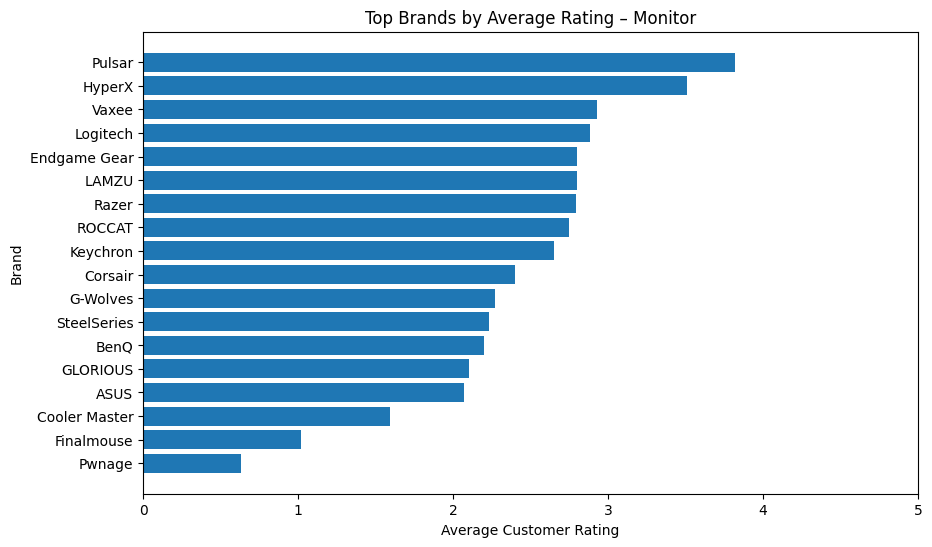

In [3]:
import pandas as pd
from rdb_conn import sql_query

category_name = "Mouse"
query = f"""
SELECT 
    b.brand_name,
    ROUND(AVG(p.avg_customer_rating), 2) AS avg_rating,
    COUNT(*) AS product_count
FROM products p
JOIN brands b ON p.brand_id = b.brand_id
WHERE p.category_name = '{category_name}'
GROUP BY b.brand_name
HAVING COUNT(*) > 5
ORDER BY avg_rating DESC;
"""

rows, _ = sql_query(query)

df = pd.DataFrame(
    rows,
    columns=["brand_name", "avg_rating", "product_count"],
)

display(df.head())
plot_top_brands(df, "Monitor")

In [4]:
category_name = "Monitor"
query = f"""
SELECT p.product_id, r.review_title, r.review_text 
FROM products p
JOIN reviews r ON p.product_id = r.product_id
WHERE p.category_name = '{category_name}';
"""

rows, _ = sql_query(query)

df = pd.DataFrame(
    rows,
    columns=["product_id", "review_title", "review_text"],
)
df.head()

2025-12-03 01:04:57,385 INFO:Time taken to fetch response: 0.32 seconds.


,product_id,review_title,review_text
0,3420,Best bang for buck gaming monitor,"The most perfect, most affordable gaming monit..."
1,3420,So worth it!,Phenomenal monitor. I’ve been really impressed...
2,3420,Awesome Monitor Highly recommend,This is a great monitor. The picture and resol...
3,3420,Really good monitor!,"Great monitor! Can be overclocked to 280Hz, ha..."
4,3420,Great for gaming and most other needs,This Dell monitor is exceptional in every poss...


In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

/Users/prashantrao/PythonWorkspace/ML5707/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch 

def predict_stars(text: str) -> int:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=-1).item()
    # classes are 0..4 → 1..5 stars
    return 1 if predicted_class_id > 3 else 0

print(predict_stars("This monitor is amazing for gaming!"))      # e.g., 5
print(predict_stars("Terrible ghosting and bad colors.")) 

1
0


In [7]:
sentiment_labels = []

for i in range(0, len(df)):
    batch_texts = df["review_text"].iloc[i]
    labels = predict_stars(batch_texts)
    sentiment_labels.append(labels)

df["sentiment"] = sentiment_labels

In [8]:
df.head()

,product_id,review_title,review_text,sentiment
0,3420,Best bang for buck gaming monitor,"The most perfect, most affordable gaming monit...",1
1,3420,So worth it!,Phenomenal monitor. I’ve been really impressed...,1
2,3420,Awesome Monitor Highly recommend,This is a great monitor. The picture and resol...,1
3,3420,Really good monitor!,"Great monitor! Can be overclocked to 280Hz, ha...",1
4,3420,Great for gaming and most other needs,This Dell monitor is exceptional in every poss...,1


In [9]:
threshold = 0.8

agg = (
    df
    .groupby("product_id")["sentiment"]
    .agg(["size", "mean"])
)

filtered = agg[(agg["size"] > 4) & (agg["mean"] > threshold)]

product_ids = filtered.index.tolist()
filtered

,size,mean
product_id,,
3420,5,1.0
3554,5,1.0
3596,5,1.0
3619,5,1.0
3795,5,1.0
3822,5,1.0
3836,5,1.0
3954,5,1.0
3955,5,1.0


In [10]:
from nodes import text_to_sql

query = text_to_sql(f"Fetch all monitor specifications for product IDs: {product_ids}")
response, cols = sql_query(query)

2025-12-03 01:05:53,530 INFO:SQL Query:
SELECT p.product_id, p.product_name, ms.size_inch, ms.curve_radius, ms.wall_mount, ms.borders_size_cm, 
       ms.brightness_rating, ms.response_time_rating, ms.hdr_picture_rating, ms.sdr_picture_rating, 
       ms.color_accuracy_rating, ms.pixel_type, ms.subpixel_layout, ms.backlight, ms.color_depth_bit, 
       ms.native_contrast, ms.contrast_with_local_dimming, ms.local_dimming, ms.sdr_real_scene_cdm2, 
       ms.sdr_peak_100_window_cdm2, ms.sdr_sustained_100_window_cdm2, ms.hdr_real_scene_cdm2, 
       ms.hdr_peak_100_window_cdm2, ms.hdr_sustained_100_window_cdm2, ms.minimum_brightness_cdm2, 
       ms.color_washout_from_left_degrees, ms.color_washout_from_right_degrees, 
       ms.color_shift_from_left_degrees, ms.color_shift_from_right_degrees, 
       ms.brightness_loss_from_left_degrees, ms.brightness_loss_from_right_degrees, 
       ms.black_level_raise_from_left_degrees, ms.black_level_raise_from_right_degrees, 
       ms.black_uniformi

In [16]:
df = pd.DataFrame(response, columns=cols)
df.describe().loc["mean"]

product_id                              3770.636364
color_depth_bit                            9.090909
color_washout_from_left_degrees           42.909091
color_washout_from_right_degrees          44.090909
color_shift_from_left_degrees             48.818182
color_shift_from_right_degrees            54.090909
brightness_loss_from_left_degrees         47.181818
brightness_loss_from_right_degrees        48.727273
black_level_raise_from_left_degrees       58.090909
black_level_raise_from_right_degrees      57.272727
native_refresh_rate_hz                   181.636364
max_refresh_rate_hz                      189.000000
max_refresh_rate_over_hdmi_hz            169.714286
usbc_ports                                 0.375000
Name: mean, dtype: float64

In [19]:
df.describe(include='object').loc["top"]

product_name                        Dell G2524H
size_inch                                  27.0
curve_radius                         Not Curved
wall_mount                         VESA 100x100
borders_size_cm                            0.80
brightness_rating                           3.1
response_time_rating                        7.9
hdr_picture_rating                          2.5
sdr_picture_rating                          6.1
color_accuracy_rating                       7.8
pixel_type                                  IPS
subpixel_layout                             RGB
backlight                                  Edge
native_contrast                          1195.0
contrast_with_local_dimming              1033.0
sdr_real_scene_cdm2                      332.00
sdr_peak_100_window_cdm2                 329.00
sdr_sustained_100_window_cdm2            329.00
hdr_real_scene_cdm2                      556.00
hdr_peak_100_window_cdm2                 632.00
hdr_sustained_100_window_cdm2           